# Convert keras to tflite 

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/Github
%cd 'LacmusTflite'

Mounted at /content/drive/
/content/drive/MyDrive/Github
/content/drive/MyDrive/Github/LacmusTflite


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from utils import *
from PIL import ImageDraw, Image
import time
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import pandas as pd

saved_model_dir = 'snapshots/MobileNetV3Small224/'
TFLITE_FILE_PATH = 'model_M3S.tflite'

In [ ]:
saved_model_dir = 'snapshots/M3S 256 relu Попытка 4/'

In [ ]:
def representative_dataset():
    for _ in range(100):
      data = np.random.rand(1, 224, 224, 3)
      yield [data.astype(np.float32)]

In [ ]:
# Convert the model

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_types = [tf.float16]

tflite_model = converter.convert()

In [ ]:
# Save the model.
with open(TFLITE_FILE_PATH, 'wb') as f:
  f.write(tflite_model)

In [ ]:
int_converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
int_converter.optimizations = [tf.lite.Optimize.DEFAULT]
int_converter.representative_dataset = representative_dataset
int_converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
int_converter.inference_input_type = tf.int8  # or tf.uint8
int_converter.inference_output_type = tf.int8  # or tf.uint8
tflite_quant_model = int_converter.convert()

In [ ]:
with open('int8_'+TFLITE_FILE_PATH, 'wb') as f:
  f.write(tflite_quant_model)

## Prepare data 

In [ ]:
B = 0
INPUT_CROP_SIZE, FEATURE_MAP_SIZE = EFFICIENT_NET_SIZES[B]
BIG_CROP_SIZE = int(INPUT_CROP_SIZE * 1.2)
os.listdir(DATA_DIR)

['JPEGImages', 'ImageSets', 'Annotations']

In [ ]:
with open(DATA_DIR+'/ImageSets/Main/test.txt') as f:
    test_i = f.read().split('\n')[:-1]

test_idxs = [int(t) for t in test_i]

def test_gen():
    for i in test_idxs:
        out = crop_sample(i, INPUT_CROP_SIZE, FEATURE_MAP_SIZE)
        for o in out:
            _, x, y, _ = o
            yield x, y
        

In [ ]:
BATCH_SIZE = 8

test_dataset = tf.data.Dataset.from_generator(
     test_gen,
     output_signature=(
         tf.TensorSpec(shape=(INPUT_CROP_SIZE, INPUT_CROP_SIZE, 3), dtype=tf.uint8),
         tf.TensorSpec(shape=(FEATURE_MAP_SIZE, FEATURE_MAP_SIZE), dtype=tf.uint8)
     )
).batch(BATCH_SIZE).prefetch(BATCH_SIZE)

In [ ]:
it = iter(test_gen())

In [ ]:
sample = next(it)
sample[0].shape, sample[1].shape

((224, 224, 3), (7, 7))

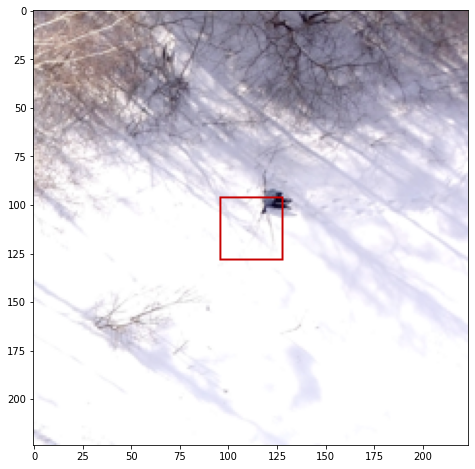

In [ ]:
plt.figure(figsize=(8,8))

img_arr = sample[0]
y = sample[1].reshape((7,7))

img = tf.keras.utils.array_to_img(img_arr)
xy = np.array(np.where(y==1)).ravel()[::-1]
bb = np.array([xy, xy+1]).ravel() * 32

draw = ImageDraw.Draw(img)
draw.rectangle(bb.tolist(), outline=(200,0,0))
y_img = Image.fromarray(y*255)
y_img=y_img.resize((INPUT_CROP_SIZE, INPUT_CROP_SIZE))


plt.imshow(img)
plt.show()  

## Load Keras model

In [ ]:
# import itertools    

# it=itertools.islice(it, 24)

In [ ]:
# it

In [ ]:
# sample = next(it)
#sample[0].shape, sample[1].shape

In [ ]:
x, y = sample

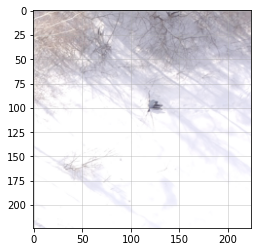

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

major_ticks = np.arange(0, 101, 20)
ax.grid(which='major', alpha=0.5)
plt.imshow(x)
#plt.show()  

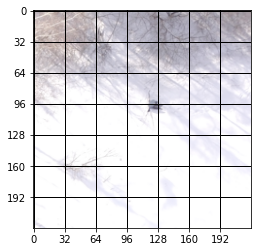

In [ ]:
plt.figure()
im = plt.imshow(x)

ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 224, 32))
ax.set_yticks(np.arange(0, 224, 32))

#

#

# Gridlines based on minor ticks
ax.grid(which='major', color='black', linestyle='-', linewidth=1)
plt.show()

In [ ]:

model = tf.keras.models.load_model(saved_model_dir, compile=False )

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling (Rescaling)          (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling[0][0]']              
                                16)                                                           

In [ ]:
start = time.time()
pred=model(np.expand_dims(x, 0))
end = time.time()
#normal_time=str((end - start)*(10**3))+ 'ms'
print('time for image: ',(end - start)*(10**3),'ms')

time for image:  9282.475471496582 ms


In [ ]:
i=0
start = time.time()
while i <1000:
  i+=1
  pred=model(np.expand_dims(x, 0))
end = time.time()
normal_time=str((end - start)*(10**3)/1000)+ 'ms'
print('time for image: ',(end - start)*(10**3)/1000,'ms')

time for image:  93.17364120483398 ms


In [ ]:
import seaborn as sns

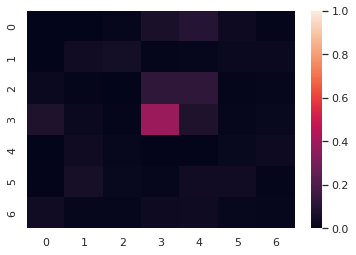

In [ ]:

sns.set()
ax = sns.heatmap(pred.numpy().reshape(7, 7), vmin=0, vmax=1)
plt.show()

In [ ]:
thresh=0.3

In [ ]:
precision = tf.keras.metrics.Precision(thresholds=thresh)
recall = tf.keras.metrics.Recall(thresholds=thresh)
auc = tf.keras.metrics.AUC()

In [ ]:
model.compile(metrics=[precision, recall, auc])

In [ ]:
start = time.time()
loss,prec,rec,auc =model.evaluate(test_dataset)
end = time.time()
print('time per image: ',(end - start)/sum(1 for x in test_gen())*10**3,'ms')
print(loss,prec,rec,auc)

23/23 [==============================] - 54s 2s/step - loss: 0.0000e+00 - precision: 0.7075 - recall: 0.8320 - auc: 0.9935
time per image:  463.9448086420695 ms
0.0 0.7074829936027527 0.8320000171661377 0.9935263395309448


In [ ]:
normal_model_res=['M3S',prec,rec,auc]

In [ ]:
normal_time

'93.17364120483398ms'

In [ ]:
pred=model.predict(test_dataset)

In [ ]:
pred.shape

(180, 7, 7, 1)

In [ ]:
pred.reshape(-1)

array([0.00038727, 0.00094527, 0.01556755, ..., 0.01714285, 0.02414628,
       0.01959582], dtype=float32)

In [ ]:
y[0]

array([0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [ ]:
test_gen()

<generator object test_gen at 0x7f563f6f55d0>

In [ ]:
y = np.concatenate([y for x, y in test_dataset], axis=0)

In [ ]:
y.shape

(180, 7, 7)

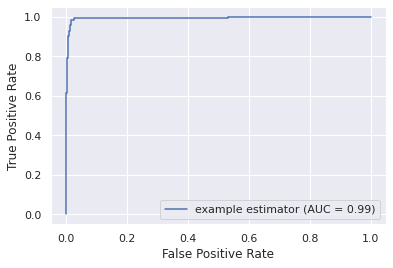

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y.reshape(-1), pred.reshape(-1))
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='example estimator')
display.plot()

plt.show()

In [ ]:
l=list(np.round(np.arange(0,1.01,0.01),2))
thr=0.3
spec=[]
rec=[]
prec=[]
acc=[]
pcor=[]
for i in l:
  cm = confusion_matrix(y.reshape(-1), pred.reshape(-1)>i)
  spec.append(cm[0,0]/(cm[0,0]+cm[0,1]))
  rec.append(cm[1,1]/(cm[1,0]+cm[1,1]))
  prec.append(cm[1,1]/(cm[1,1]+cm[0,1]))
  acc.append((cm[1,1]+cm[0,0])/sum(cm.ravel()))
  pcor.append(cm[0,0]/(cm[0,0]+cm[1,0]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in long_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0]

In [ ]:
fscore=[]
f2score=[]
b=2
for i in range(len(prec)):
  fscore.append(2*prec[i]*rec[i]/(rec[i]+prec[i]))
  f2score.append((1+b**2)*prec[i]*rec[i]/(rec[i]+b**2 * prec[i]))

Text(0.5, 0, 'threshold')

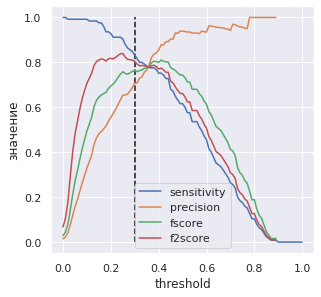

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
#plt.plot(l,spec)
plt.plot(l,rec)
plt.plot(l,prec)
plt.plot(l,fscore)
plt.plot(l,f2score)
plt.vlines(thr, 0,1,ls='--')
plt.legend( (
    #'specificity', 
    'sensitivity','precision','fscore','f2score'))
plt.ylabel('значение')
plt.xlabel('threshold')

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
print(classification_report(y.reshape(-1), pred.reshape(-1)>0.3,digits=3))

              precision    recall  f1-score   support

           0      0.998     0.995     0.996      8695
           1      0.707     0.832     0.765       125

    accuracy                          0.993      8820
   macro avg      0.853     0.914     0.881      8820
weighted avg      0.993     0.993     0.993      8820



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

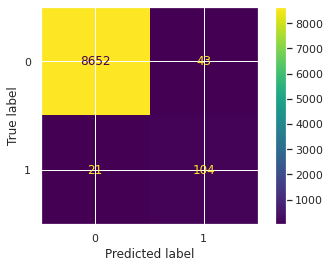

In [ ]:
ConfusionMatrixDisplay.from_predictions(y.reshape(-1), pred.reshape(-1)> 0.3, cmap='viridis',ax=None)
plt.show()

In [ ]:
n_thr=(np.argmax(np.array(rec)<0.9)-1)/100
n_thr

0.25

In [ ]:
f_thr=(np.nanargmax(np.array(f2score)))/100
f_thr

0.25

In [ ]:
f2score[np.nanargmax(np.array(f2score))]

0.8395245170876672

In [ ]:
f2score[20:35]

[0.8180535966149506,
 0.8154506437768241,
 0.8225108225108225,
 0.8309037900874636,
 0.8382352941176471,
 0.8395245170876672,
 0.8233532934131736,
 0.8132530120481929,
 0.8118361153262519,
 0.8103975535168196,
 0.80370942812983,
 0.7919254658385093,
 0.7849293563579278,
 0.7861635220125787,
 0.7844690966719493]

In [ ]:
#f_thr=0.27

Text(0.5, 0, 'threshold')

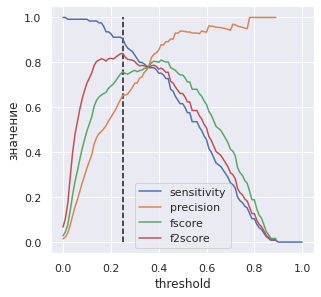

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
#plt.plot(l,spec)
plt.plot(l,rec)
plt.plot(l,prec)
plt.plot(l,fscore)
plt.plot(l,f2score)
plt.vlines(n_thr, 0,1,ls='--')
plt.legend( (
    #'specificity', 
    'sensitivity','precision','fscore','f2score'))
plt.ylabel('значение')
plt.xlabel('threshold')

In [ ]:
print(classification_report(y.reshape(-1), pred.reshape(-1)> n_thr,digits=3))

              precision    recall  f1-score   support

           0      0.999     0.993     0.996      8695
           1      0.653     0.904     0.758       125

    accuracy                          0.992      8820
   macro avg      0.826     0.949     0.877      8820
weighted avg      0.994     0.992     0.992      8820



In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y.reshape(-1), pred.reshape(-1)> n_thr)

print(cf_matrix)

[[8635   60]
 [  12  113]]


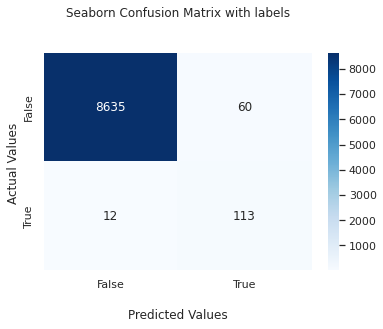

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order+
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

Text(0.5, 0, 'threshold')

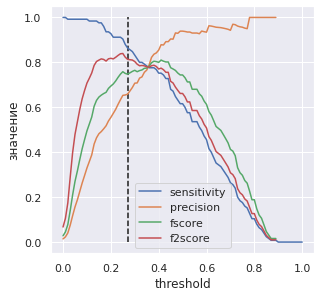

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
#plt.plot(l,spec)
plt.plot(l,rec)
plt.plot(l,prec)
plt.plot(l,fscore)
plt.plot(l,f2score)
plt.vlines(f_thr, 0,1,ls='--')
plt.legend( (
    #'specificity', 
    'sensitivity','precision','fscore','f2score'))
plt.ylabel('значение')
plt.xlabel('threshold')

In [ ]:
print(classification_report(y.reshape(-1), pred.reshape(-1)> f_thr,digits=3))

              precision    recall  f1-score   support

           0      0.998     0.994     0.996      8695
           1      0.659     0.864     0.747       125

    accuracy                          0.992      8820
   macro avg      0.828     0.929     0.872      8820
weighted avg      0.993     0.992     0.992      8820



In [ ]:
from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(y.reshape(-1), pred.reshape(-1)> f_thr)

print(cf_matrix)

[[8639   56]
 [  17  108]]


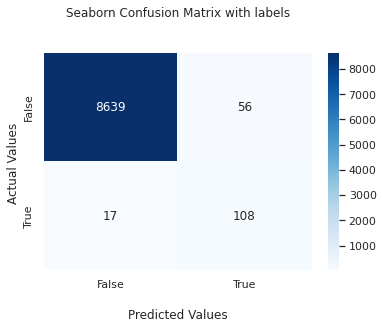

In [ ]:
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order+
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

## Tflite inference 

In [ ]:
interpreter = tf.lite.Interpreter(TFLITE_FILE_PATH)

In [ ]:
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
interpreter.get_input_details()

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_input_1:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 1, 1, 3], dtype=int32),
  'shape_signature': array([-1, -1, -1,  3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
interpreter.get_output_details()

[{'dtype': numpy.float32,
  'index': 251,
  'name': 'StatefulPartitionedCall:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([1, 1, 1, 1], dtype=int32),
  'shape_signature': array([-1, -1, -1,  1], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
x.shape

(224, 224, 3)

In [ ]:
x.astype('float32').shape

(224, 224, 3)

In [ ]:
interpreter.resize_tensor_input(input_details[0]["index"], [1,224, 224, 3])

NameError: ignored

In [ ]:
interpreter.resize_tensor_input(output_details[0]['index'], (8, 7,7))

In [ ]:
interpreter.get_input_details()

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'serving_default_input_1:0',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([  1, 224, 224,   3], dtype=int32),
  'shape_signature': array([-1, -1, -1,  3], dtype=int32),
  'sparsity_parameters': {}}]

In [ ]:
interpreter.allocate_tensors()

In [ ]:
np.expand_dims(x.astype('float32'), 0).shape

(1, 224, 224, 3)

In [ ]:
#%%time
start = time.time()
interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x.astype('float32'), 0))
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
quant_time=str((end - start)*(10**3))+ 'ms'
print('time for image: ',(end - start)*(10**3),'ms')

time for image:  33.77723693847656 ms


In [ ]:
i=0
start = time.time()
while i <1000:
  i+=1
  interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x.astype('float32'), 0))
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
#quant_time=str((end - start)*(10**3)/1000)+ 'ms'
print('time for image: ',(end - start)*(10**3)/1000,'ms')

time for image:  8.216105699539185 ms


In [ ]:
start = time.time()
k=180
it = iter(test_gen())
for i in range(k):
  x,y = next(it)

  interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x.astype('float32'), 0))
  interpreter.invoke()
  output_data = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
print('time per image: ',(end - start)/k*(10**3),'ms')

time per image:  97.08154863781398 ms


In [ ]:

# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter,test_images=test_gen,tresh=0.3,astype='float32'):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]
  start = time.time()
  # Run predictions on every image in the "test" dataset.
  predictions = []
  test_labels=[]
  for test_image in test_gen():
    test_labels.append(test_image[1])
    test_image=test_image[0]
    
    test_image = np.expand_dims(test_image, axis=0).astype(astype)
    interpreter.set_tensor(input_index, test_image)
    
    interpreter.invoke()

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    pred = interpreter.get_tensor(output_index)
    predictions.append(pred)
  end = time.time()
  print('time per image: ',(end - start)/sum(1 for x in test_gen())*10**3,'ms')
  # Compare prediction results with ground truth labels to calculate accuracy.

  #print(np.array(predictions).reshape((-1)).shape,np.array(test_labels).shape)
  predictions=(np.array(predictions).reshape(-1))
  test_labels=(np.array(test_labels).reshape(-1))
  print (len(predictions))
  tn, fp, fn, tp = confusion_matrix(test_labels,predictions>=tresh).ravel()
  print(tn,fp,fn,tp)
  
  accuracy = (tp+tn)/(fp+fn+tp+tn)
  precision=tp/(tp+fp)
  recall=tp/(tp+fn)
  fpr, tpr, thresholds =metrics.roc_curve(test_labels, predictions)
  AUC=metrics.auc(fpr, tpr)
  return accuracy,precision,recall,AUC

In [ ]:
%%time
print(evaluate_model(interpreter))

time per image:  96.3301804330614 ms
8820
8653 42 20 105
(0.9929705215419501, 0.7142857142857143, 0.84, 0.993751811385854)
CPU times: user 32.6 s, sys: 510 ms, total: 33.1 s
Wall time: 33.1 s


In [ ]:
accuracy,precision,recall,AUC=evaluate_model(interpreter)

time per image:  96.45316733254326 ms
8820
8653 42 20 105


In [ ]:
quant_res= ['Quant float16',precision,recall,AUC]

In [ ]:

interpreter.resize_tensor_input(input_details[0]['index'], (8, 224, 224, 3))
interpreter.resize_tensor_input(output_details[0]['index'], (8, 7,7))
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [ ]:
%%time
start = time.time()
interpreter.set_tensor(input_details[0]['index'],np.array(next(iter(test_dataset))[0]).astype('float32'))
# Run inference
interpreter.invoke()
# Get prediction results
tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
end = time.time()
print('time per image: ',(end - start)/8*(10**3),'ms')

time per image:  149.6465504169464 ms
CPU times: user 1.16 s, sys: 37.1 ms, total: 1.2 s
Wall time: 1.2 s


In [ ]:
quant_time

'33.77723693847656ms'

##Testing int8 quantization

In [ ]:
int_interpreter = tf.lite.Interpreter('int8_'+TFLITE_FILE_PATH)

In [ ]:
int_interpreter.resize_tensor_input(input_details[0]["index"], [1,224, 224, 3])

In [ ]:
int_interpreter.resize_tensor_input(output_details[0]['index'], (8, 7,7))

In [ ]:
int_interpreter.allocate_tensors()

# Get input and output tensors.
input_details = int_interpreter.get_input_details()
output_details = int_interpreter.get_output_details()

In [ ]:
%%time
start = time.time()
int_interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0).astype('int8'))
int_interpreter.invoke()
output_data = int_interpreter.get_tensor(output_details[0]['index'])
end = time.time()
int_quant_time=str((end - start)*(10**3))+ 'ms'
print('time for image: ',(end - start)*(10**3),'ms')

time for image:  235.0614070892334 ms
CPU times: user 229 ms, sys: 4.97 ms, total: 234 ms
Wall time: 235 ms


In [ ]:
i=0
start = time.time()
while i <1000:
  i+=1
  int_interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0).astype('int8'))
  int_interpreter.invoke()
  output_data = int_interpreter.get_tensor(output_details[0]['index'])
end = time.time()
#quant_time=str((end - start)*(10**3)/1000)+ 'ms'
print('time for image: ',(end - start)*(10**3)/1000,'ms')

time for image:  219.1922163963318 ms


In [ ]:
start = time.time()
k=180
it = iter(test_gen())
for i in range(k):
  x,y = next(it)

  int_interpreter.set_tensor(input_details[0]['index'], np.expand_dims(x, 0).astype('int8'))
  int_interpreter.invoke()
  output_data = int_interpreter.get_tensor(output_details[0]['index'])
end = time.time()
print('time per image: ',(end - start)/k*(10**3),'ms')

time per image:  307.5190173255073 ms


In [ ]:
print(evaluate_model(int_interpreter,astype='int8'))

time per image:  306.6367798381381 ms
8820
8695 0 125 0
(0.985827664399093, nan, 0.0, 0.6145867740080506)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
accuracy,precision,recall,AUC=evaluate_model(int_interpreter,astype='int8')
int_quant_res= ['Quant int8',precision,recall,AUC]

time per image:  306.0902754465739 ms
8820
8695 0 125 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in long_scalars


In [ ]:
normal_model_res

['M3S', 0.7074829936027527, 0.8320000171661377, 0.9935263395309448]

In [ ]:
normal_model_res.append(normal_time)
quant_res.append(quant_time)
int_quant_res.append(int_quant_time)

In [ ]:
cols=['Model', 'Precision','Recall','auc','inference time']
l=len(cols)
lst = [normal_model_res[:l],quant_res[:l],int_quant_res[:l]]
    
df = pd.DataFrame(lst, columns =cols)[['Model', 'Precision','Recall','inference time']]
df

,Model,Precision,Recall,inference time
0,M3S,0.707483,0.832,93.17364120483398ms
1,Quant float16,0.714286,0.840,33.77723693847656ms
2,Quant int8,NaN,0.000,235.0614070892334ms
